In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.append('../')

In [4]:
import copy
from dataclasses import dataclass
import numpy as np
import os
import pandas as pd

from datasets import Dataset, Features, Value
import evaluate
from transformers import DataCollatorWithPadding
from transformers import AutoModelForSequenceClassification, AutoTokenizer, TrainingArguments, Trainer, TrainerCallback
from transformers import pipeline
import torch

/usr/local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
pwd

'/code/notebooks'

In [6]:
df = pd.read_csv("../data/raw/dataset.csv")
df.head()

,label,text
0,ham,"Subject: flow volumes at oxy gladewater , mete..."
1,ham,Subject: 02 / 00 natural gas nomination\r\nenr...
2,spam,Subject: re : official us goverment program\r\...
3,ham,"Subject: hpl nom for march 17 , 2001\r\n( see ..."
4,ham,"Subject: hpl noms for april 17 , 2001\r\n( see..."


In [7]:
df.shape

(4136, 2)

In [8]:
df.drop_duplicates(inplace = True)

In [9]:
df.shape

(4019, 2)

In [10]:
print(pd.DataFrame(df.isnull().sum()))

       0
label  0
text   0


In [11]:
df['label'].value_counts()

label
ham     2854
spam    1165
Name: count, dtype: int64

<Axes: >

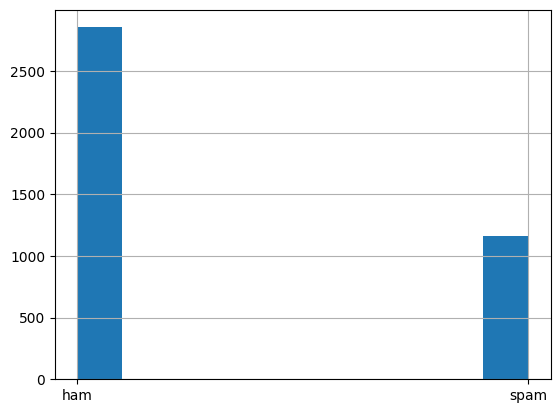

In [12]:
df['label'].hist()

In [13]:
def read_filtered_sms(df, start_idx, end_idx, sms_filter):
    for sms in df[df['label']==sms_filter]['text'][start_idx:end_idx]:
        print('-'*100)
        print(sms)

In [14]:
#read_filtered_sms(df, 0, 10, 'ham')

In [15]:
#read_filtered_sms(df, 10, 15, 'spam')

In [16]:
#df['label'] = df.label.map({'ham':0, 'spam':1})

In [17]:
df.head()

,label,text
0,ham,"Subject: flow volumes at oxy gladewater , mete..."
1,ham,Subject: 02 / 00 natural gas nomination\r\nenr...
2,spam,Subject: re : official us goverment program\r\...
3,ham,"Subject: hpl nom for march 17 , 2001\r\n( see ..."
4,ham,"Subject: hpl noms for april 17 , 2001\r\n( see..."


In [18]:
dataset = Dataset.from_pandas(df)

In [19]:
dataset.features

{'label': Value(dtype='string', id=None),
 'text': Value(dtype='string', id=None),
 '__index_level_0__': Value(dtype='int64', id=None)}

In [20]:
dataset = dataset.class_encode_column("label")
dataset

Casting to class labels: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4019/4019 [00:00<00:00, 226708.46 examples/s]


Dataset({
    features: ['label', 'text', '__index_level_0__'],
    num_rows: 4019
})

In [21]:
dataset.features

{'label': ClassLabel(names=['ham', 'spam'], id=None),
 'text': Value(dtype='string', id=None),
 '__index_level_0__': Value(dtype='int64', id=None)}

In [22]:
ds = dataset.train_test_split(test_size=0.1, seed=42, stratify_by_column="label")
ds

DatasetDict({
    train: Dataset({
        features: ['label', 'text', '__index_level_0__'],
        num_rows: 3617
    })
    test: Dataset({
        features: ['label', 'text', '__index_level_0__'],
        num_rows: 402
    })
})

In [23]:
ds["train"].features

{'label': ClassLabel(names=['ham', 'spam'], id=None),
 'text': Value(dtype='string', id=None),
 '__index_level_0__': Value(dtype='int64', id=None)}

## Tokenize the sms
Use the tokenizer to tokenize the sms in which we want to classify as `SPAM` / `NON SPAM`. 

In [24]:
model_path = 'mshenoda/roberta-spam'
tokenizer = AutoTokenizer.from_pretrained(model_path)

tokenizer_config.json: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1.31k/1.31k [00:00<00:00, 3.63MB/s]
vocab.json: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 999k/999k [00:00<00:00, 2.87MB/s]
merges.txt: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 456k/456k [00:00<00:00, 1.82MB/s]
special_tokens_map.json: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 957/957 [00:00<00:00, 5.43MB/s]


In [25]:
def preprocess_function(ds):
    return tokenizer(ds['text'], truncation=True, return_overflowing_tokens=True)

In [26]:
# https://huggingface.co/learn/nlp-course/chapter5/3?fw=pt#the-%3Ccode%3Emap()%3C/code%3E-method%E2%80%99s-superpowers
tokenized_sms = ds.map(preprocess_function, batched=True, remove_columns=dataset.column_names)
tokenized_sms

Map: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 402/402 [00:00<00:00, 2519.65 examples/s]


DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'overflow_to_sample_mapping'],
        num_rows: 4662
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'overflow_to_sample_mapping'],
        num_rows: 520
    })
})

In [27]:
def tokenize_and_split(ds):
    result = tokenizer(
        ds["text"],
        truncation=True,
        max_length=128,
        return_overflowing_tokens=True,
    )
    # Extract mapping between new and old indices
    sample_map = result.pop("overflow_to_sample_mapping")
    for key, values in ds.items():
        result[key] = [values[i] for i in sample_map]
    return result


In [28]:
tokenized_sms = ds.map(tokenize_and_split, batched=True)
tokenized_sms

Map: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 402/402 [00:00<00:00, 3302.65 examples/s]


DatasetDict({
    train: Dataset({
        features: ['label', 'text', '__index_level_0__', 'input_ids', 'attention_mask'],
        num_rows: 11089
    })
    test: Dataset({
        features: ['label', 'text', '__index_level_0__', 'input_ids', 'attention_mask'],
        num_rows: 1247
    })
})

In [29]:
context_length = 64

outputs = tokenizer(
    ds['train'][:2]['text'],
    truncation=True,
    max_length=context_length,
    return_overflowing_tokens=True,
    return_length=True,
)

print(f"Input IDs length: {len(outputs['input_ids'])}")
print(f"Input chunk lengths: {(outputs['length'])}")
print(f"Chunk mapping: {outputs['overflow_to_sample_mapping']}")

Input IDs length: 5
Input chunk lengths: [64, 64, 64, 15, 41]
Chunk mapping: [0, 0, 0, 0, 1]


We can see that we get 6 segments in total from those 2 sms examples. Looking at the chunk lengths, we can see that the chunks at the ends of the first sms have less than 128 tokens (97). These represent just a small fraction of the total chunks that we have, so we can safely throw them away. With the overflow_to_sample_mapping field, we can also reconstruct which chunks belonged to which input samples.

With this operation we’re using a handy feature of the Dataset.map() function in Datasets, which is that it does not require one-to-one maps; we can create batches with more or fewer elements than the input batch. This is useful when doing operations like data augmentation or data filtering that change the number of elements. In our case, when tokenizing each element into chunks of the specified context size, we create many samples from each sms. We just need to make sure to delete the existing columns, since they have a conflicting size. If we wanted to keep them, we could repeat them appropriately and return them within the Dataset.map() call:

Create a batch of examples using `DataCollatorWithPadding`. It’s more efficient to *dynamically pad* the sentences to the longest length in a batch during collation, instead of padding the whole dataset to the maximum length.

In [30]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

### Evaluate

In [31]:
def compute_metrics(y_pred):
    logits, labels = y_pred
    predictions = np.argmax(logits, axis=1)
    return evaluate.load("f1").compute(predictions=predictions, references=labels, average="macro")

### Train 

In [32]:
set(ds['train']['label'])

{0, 1}

In [33]:
id2label = {0: "ham", 1: "spam"}
label2id = {"ham": 0, "spam": 1}

model = AutoModelForSequenceClassification.from_pretrained(
    "mshenoda/roberta-spam", num_labels=2, id2label=id2label, label2id=label2id
)

config.json: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 735/735 [00:00<00:00, 2.40MB/s]
model.safetensors: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 499M/499M [02:16<00:00, 3.64MB/s]


####  training hyperparameters

In [34]:
training_args = TrainingArguments(
    output_dir="roberta-spam",
    learning_rate=5e-4,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=2,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    use_cpu=True,
    #load_best_model_at_end=True,
    push_to_hub=False,
)

In [35]:
ds['train']

Dataset({
    features: ['label', 'text', '__index_level_0__'],
    num_rows: 3617
})

In [36]:
class EvalOnTrainCallback(TrainerCallback):
    """Custom callback to evaluate on the training set during training."""

    def __init__(self, trainer) -> None:
        super().__init__()
        self._trainer = trainer

    def on_epoch_end(self, args, state, control, **kwargs):
        if control.should_evaluate:
            control_train = copy.deepcopy(control)
            self._trainer.evaluate(
                eval_dataset=self._trainer.train_dataset, metric_key_prefix="train"
            )
            return control_train

In [37]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_sms["train"],
    eval_dataset=tokenized_sms["test"],
    tokenizer=tokenizer,
    #data_collator=data_collator,
    compute_metrics=compute_metrics,
)
trainer.add_callback(EvalOnTrainCallback(trainer))

In [38]:
device = torch.device('mps')
os.environ['PYTORCH_MPS_HIGH_WATERMARK_RATIO']='0.0'
os.getenv('PYTORCH_MPS_HIGH_WATERMARK_RATIO')

'0.0'

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss


In [ ]:
trainer.save_model('../data/models/roberta-spam')

In [ ]:
pd.DataFrame(trainer.state.log_history)

### Inference
#### Load the model
Test the new fine tuned model on sms and see how it works.

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
classifier = pipeline(task="text-classification", model="mshenoda/roberta-spam")

In [ ]:
sms = "Subject: flow volumes at oxy gladewater"

classifier = pipeline(task="text-classification", model="mshenoda/roberta-spam")
classifier(sms)